In [1]:
'''
数据预处理操作
在加载数据之前，让我们还是先来定义数据预处理的操作集合。我们可以使用旋转、剪切等操作，扩大数据集合的多样性。代码如下：
'''
import torch
import torchvision
import numpy as np
from torchvision import datasets, transforms
# 用于存在标准化，因此这里定义了高斯分布所需要的两个参数：均值和标准差
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {

    'train': transforms.Compose([
        # 加入旋转等数据增强技术，加大模型训练的难度，提高模型的稳健性
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    # 测试集输入时，无需加入旋转等操作
    'val': transforms.Compose([
        # resize 操作的目的是将任意大小的图片转为模型规定的输入大小
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
data_transforms

{'train': Compose(
     RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
     RandomHorizontalFlip(p=0.5)
     ToTensor()
     Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
 ), 'val': Compose(
     Resize(size=256, interpolation=bilinear)
     CenterCrop(size=(224, 224))
     ToTensor()
     Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
 )}

In [2]:
'''
数据的加载
接下来，就让我们加载数据集合，并且将其制作成 PyTorch 能够识别的数据加载器：
'''
import os

data_dir = './data/hymenoptera_data'
# 将数据集封装到 PyTorch 中数据加载器中
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=0)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
# 判断当前环境
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)

['ants', 'bees']


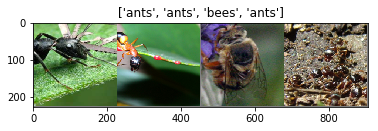

In [7]:
'''
数据可视化
接下来，我们还是利用定义好的数据加载器随机展示几张数据集中的图像：
'''
import matplotlib.pyplot as plt
%matplotlib inline


def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# 获得训练数据中的一个批次的数据
inputs, classes = next(iter(dataloaders['train']))

# 将图片拼成一个网格
out = torchvision.utils.make_grid(inputs)
# 展示图像
imshow(out, title=[class_names[x] for x in classes])

In [9]:
from torchvision import models

# 指定预训练模型的网络地址，如果不指定，则会从 PyTorch 官网上下载
# 由于官网属于外网，速度很慢。因此这里已将模型上传至云服务器中
#torch.utils.model_zoo.load_url("https://labfile.oss.aliyuncs.com/courses/2534/resnet18-5c106cde.pth")
# 加载预训练模型
# pretrained=False 表示只加载结构，不加载模型
# pretrained=True：表示都加载
model = models.resnet18(pretrained=False)
PATH = './model/resnet18-5c106cde.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
'''
那么，是否上面这个模型就可以识别蜜蜂和蚂蚁了呢？
或许细心的你已经发现，该模型的输出为 1000 个节点，
而我们对蚂蚁和蜜蜂进行分类，只需要两个输出节点。
综上，我们需要对 fc 层进行修改，使其只输出 2 个神经元节点。代码如下：
'''
import torch.nn as nn
# 获得 fc 层的输入节点数
num_ftrs = model.fc.in_features
# 重新定义 fc：输入节点数不变的情况下，将输出节点改为 2
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
'''
模型的训练与测试
损失和优化器的定义
这里我们还是采用常用的交叉熵损失作为模型训练所需的损失函数，使用 SGD 优化器来对模型进行优化求解。
'''
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion, optimizer

(CrossEntropyLoss(), SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.001
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [13]:
'''
在定义完优化器后，我们还可以定义一个学习率的变化器。传统梯度下降算法的学习率是不变的，
我们可以利用 lr_scheduler 定义一个随着 epoch 变化的学习率。这样可以更好的优化模型，提高模型的准确率和收敛速度。
'''
from torch.optim import lr_scheduler

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
step_lr_scheduler

In [14]:
'''
训练与测试
在模型训练之前，让我们先来定义两个变量 best_model_wts 和 best_acc ，用于存储最佳模型参数和最高的模型准确率。
'''
import copy
# deepcopy：深拷贝，就是保存模型的参数复制到另一个变量中
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
best_model_wts, best_acc

(OrderedDict([('conv1.weight',
               tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                           1.7083e-02, -1.2694e-02],
                         [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                          -1.2907e-01,  3.7424e-03],
                         [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                           2.5632e-01,  6.3573e-02],
                         ...,
                         [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                          -4.2058e-01, -2.5781e-01],
                         [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                           3.9359e-01,  1.6606e-01],
                         [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                          -8.2230e-02, -5.7828e-03]],
               
                        [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
                

In [15]:
import time
# 记录模型训练的开始时间
since = time.time()
# 开始训练,这里我们只设置迭代 5次
num_epochs = 5
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # 每次迭代，都会对模型进行一次训练和一次测试
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # 告诉模型，现在是对模型进行训练，即需要梯度下降
        else:
            model.eval()   # 告诉模型，现在是对模型进行测试，即不需要梯度下降

        # 定义每次跌打时的损失和准确率
        running_loss = 0.0
        running_corrects = 0

        # 遍历数据生成器，训练时 phase = train，测试时 phase = val
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 前向传播
            # 如果 phase == 'train'，则打开梯度。否则，关闭梯度
            with torch.set_grad_enabled(phase == 'train'):
                # 获得预测结果和损失
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # 如果是模型训练，则需要反向传播
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # 统计损失值和正确的数据条数
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        # 更新学习率
        if phase == 'train':
            step_lr_scheduler.step()

        # 计算当前损失和准确率
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

        # 如果此时的测试准确率比 best_acc，那么就将此时的模型存入 best_model_wts 中
        # 将准确率存入 best_acc 中
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print("-----------------------")

# 模型训练完毕，计算花费时间
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

# 加载训练过程中准确率最高的模型，作为输出的最后的模型
model.load_state_dict(best_model_wts)

Epoch 0/4
----------
train Loss: 0.6597 Acc: 0.5984
val Loss: 0.4870 Acc: 0.8170
-----------------------
Epoch 1/4
----------
train Loss: 0.5569 Acc: 0.7131
val Loss: 0.3765 Acc: 0.9085
-----------------------
Epoch 2/4
----------
train Loss: 0.4744 Acc: 0.8320
val Loss: 0.3028 Acc: 0.9216
-----------------------
Epoch 3/4
----------
train Loss: 0.4848 Acc: 0.7664
val Loss: 0.2672 Acc: 0.9150
-----------------------
Epoch 4/4
----------
train Loss: 0.4075 Acc: 0.8238
val Loss: 0.2498 Acc: 0.9346
-----------------------
Training complete in 2m 23s
Best val Acc: 0.934641


<All keys matched successfully>

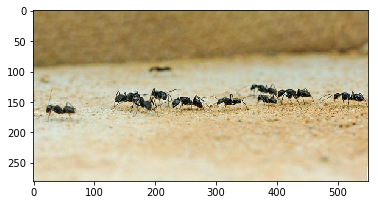

In [17]:
'''
模型的应用
接下来，让我们利用建立的模型对任意一张图片进行识别。这里我从网上随机下载了一张蚂蚁的图片，
让我们来验证一下，模型是否能够成功识别该图片。

首先将图片下载到环境中：
'''
from PIL import Image

# 可以通过修改下面路径，对需要预测的图片进行修改
infer_path = './data/ant.jpg'
img = Image.open(infer_path)
plt.imshow(img)
plt.show()

In [21]:
'''
从上图可以看到，该图像中存在很多的蚂蚁。在将图像放入模型中进行预测之前，我们需要对图片进行预处理，将图片处理成模型要求的输入格式：
'''
def load_image(file):
    im = Image.open(file)
    # 将大小修改为 224*224 符合模型输入
    im = im.resize((224, 224), Image.ANTIALIAS)
    # 建立图片矩阵
    im = np.array(im).astype(np.float32)
    # WHC->CHW
    im = im.transpose((2, 0, 1))
    im = im / 255.0
    # 转为 batch,c,w,h
    im = np.expand_dims(im, axis=0)

    print("im_shape 的维度", im.shape)
    return im


# 测试函数
img = load_image(infer_path)
img

im_shape 的维度 (1, 3, 224, 224)


array([[[[0.5803922 , 0.6039216 , 0.61960787, ..., 0.654902  ,
          0.6509804 , 0.6313726 ],
         [0.5882353 , 0.6117647 , 0.61960787, ..., 0.6509804 ,
          0.64705884, 0.6313726 ],
         [0.6       , 0.6156863 , 0.6156863 , ..., 0.6431373 ,
          0.6392157 , 0.62352943],
         ...,
         [0.8862745 , 0.8862745 , 0.8901961 , ..., 0.8862745 ,
          0.8627451 , 0.93333334],
         [0.8784314 , 0.8784314 , 0.88235295, ..., 0.89411765,
          0.8627451 , 0.94509804],
         [0.8666667 , 0.87058824, 0.8745098 , ..., 0.89411765,
          0.8666667 , 0.9490196 ]],

        [[0.49803922, 0.5176471 , 0.5294118 , ..., 0.5411765 ,
          0.52156866, 0.5058824 ],
         [0.5058824 , 0.52156866, 0.5294118 , ..., 0.5372549 ,
          0.52156866, 0.5058824 ],
         [0.52156866, 0.5294118 , 0.5254902 , ..., 0.5294118 ,
          0.5176471 , 0.50980395],
         ...,
         [0.87058824, 0.87058824, 0.8627451 , ..., 0.827451  ,
          0.80784315, 0.9

In [19]:
'''
最后让我们将读出的影像放入模型之中，进行预测：
'''
img_data = torch.tensor(img)
outputs = model(img_data)
_, preds = torch.max(outputs, 1)
print("The picture is ", class_names[preds])

The picture is  ants
